<a href="https://colab.research.google.com/github/sarcasticvibes/CoLA-Dataset-classification-via-BERT-for-Classificatio/blob/master/BERT_Fine_Tuning_Sentence_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning Tutorial with PyTorch

*Revised on 3/20/20 - Switched to `tokenizer.encode_plus` and added validation loss. See [Revision History](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=IKzLS9ohzGVu) at the end for details.*




# 1. Setup

In [0]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
!pip install transformers

     |████████████████████████████████| 675kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 12.8MB/s 
     |████████████████████████████████| 890kB 16.7MB/s 
     |████████████████████████████████| 3.8MB 24.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=3febc14656e7ab0051e9112470abbf2ee14317f8311161c6943719faba35ac9e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# 2. Loading CoLA Dataset


## 2.1. Download & Extract

The dataset is hosted on GitHub in this repo: https://nyu-mll.github.io/CoLA/

In [0]:
!wget https://nyu-mll.github.io/CoLA/cola_public_1.1.zip

--2020-06-10 21:16:11--  https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
Resolving nyu-mll.github.io (nyu-mll.github.io)... 185.199.109.153, 185.199.111.153, 185.199.110.153, ...
Connecting to nyu-mll.github.io (nyu-mll.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255330 (249K) [application/zip]
Saving to: ‘cola_public_1.1.zip’

cola_public_1.1.zip 100%[===================>] 249.35K  --.-KB/s    in 0.05s   

2020-06-10 21:16:12 (4.48 MB/s) - ‘cola_public_1.1.zip’ saved [255330/255330]



Unzip the dataset to the file system. You can browse the file system of the Colab instance in the sidebar on the left.

In [0]:
!unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


## 2.2. Parse

We can see from the file names that both `tokenized` and `raw` versions of the data are available. 

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In [0]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.head(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.
5,gj04,1,NaN,I'll fix you a drink.
6,gj04,1,NaN,Fred watered the plants flat.
7,gj04,1,NaN,Bill coughed his way out of the restaurant.
8,gj04,1,NaN,We're dancing the night away.
9,gj04,1,NaN,Herman hammered the metal flat.


The two properties we actually care about are the the `sentence` and its `label`, which is referred to as the "acceptibility judgment" (0=unacceptable, 1=acceptable).

In [0]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
3641,Mary waited for the bus and to go home.,0
6053,John said Heidi to eat the broccoli.,0
1142,He figured out that.,0
3547,They read the under book.,0
2285,The pasture is herding with cattle.,0




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [0]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [0]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

## 3.3. Tokenize Dataset

In [0]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


Just in case there are some longer test sentences, I'll set the maximum length to 64.


In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:

    encoded_dict = tokenizer.encode_plus(sent,    
                                         add_special_tokens = True, 
                                         max_length = 64, 
                                         pad_to_max_length = True, 
                                         return_attention_mask = True, 
                                         return_tensors = 'pt')
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [0]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

# 4. Train Our Classification Model

## 4.1. BertForSequenceClassification

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels = 2,  output_attentions = False,output_hidden_states = False)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

## 4.2. Optimizer & Learning Rate Scheduler

In [0]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

## 4.3. Training Loop

Define a helper function for calculating accuracy.

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import random
import numpy as np
from tqdm.autonotebook import tqdm

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []

# For each epoch...
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for batch in tqdm( train_dataloader,  total=len(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader) 
    print("  Training Loss: {0:.2f}".format(avg_train_loss))           
    
    print("")
    print("Running Validation...")


    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader, total=len(validation_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append({'epoch': epoch_i + 1,
                           'Training Loss': avg_train_loss,
                           'Valid. Loss': avg_val_loss,
                           'Valid. Accur.': avg_val_accuracy,})

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...



  Training Loss: 0.44

Running Validation...



  Accuracy: 0.84
  Validation Loss: 0.36

======== Epoch 2 / 3 ========
Training...



  Training Loss: 0.22

Running Validation...



  Accuracy: 0.86
  Validation Loss: 0.38

======== Epoch 3 / 3 ========
Training...



  Training Loss: 0.12

Running Validation...



  Accuracy: 0.86
  Validation Loss: 0.47

Training complete!


Let's view the summary of the training process.

In [0]:
import pandas as pd
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats

,epoch,Training Loss,Valid. Loss,Valid. Accur.
0,1,0.44,0.36,0.84
1,2,0.22,0.38,0.86
2,3,0.12,0.47,0.86


Since the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

We can use `EarlyStopping` to prevent the model from over-fitting

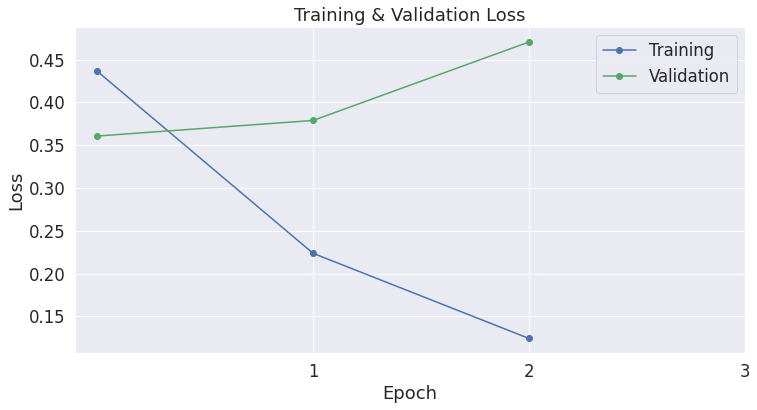

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation


In [0]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
sentences = df.sentence.values
labels = df.label.values
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(sent,
                                         add_special_tokens = True, 
                                         max_length = 64,           
                                         pad_to_max_length = True,
                                         return_attention_mask = True,  
                                         return_tensors = 'pt')
   
    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

predictions , true_labels = [], []


for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch


  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [0]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [0]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


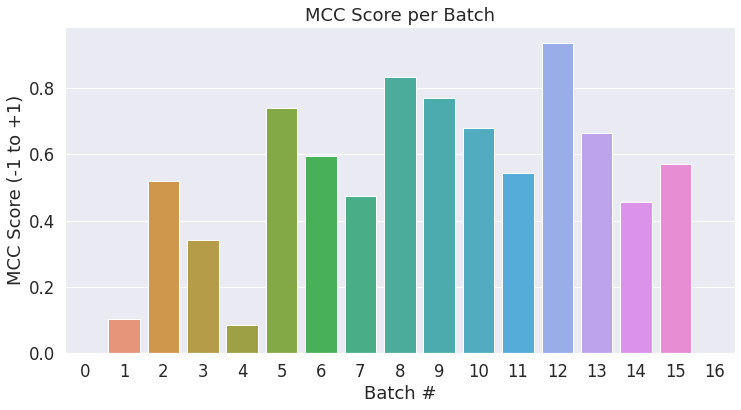

In [0]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [0]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.540


In [0]:
df['predictions'] = flat_predictions

In [0]:
len(df[df['label'] == df['predictions']])/len(df)

0.812015503875969

In [0]:
df.head(20)

,sentence_source,label,label_notes,sentence,predictions
0,clc95,1,NaN,Somebody just left - guess who.,1
1,clc95,1,NaN,"They claimed they had settled on something, bu...",1
2,clc95,1,NaN,"If Sam was going, Sally would know where.",1
3,clc95,1,NaN,"They're going to serve the guests something, b...",1
4,clc95,1,NaN,She's reading. I can't imagine what.,1
5,clc95,1,NaN,John said Joan saw someone from her graduating...,1
6,clc95,0,*,John ate dinner but I don't know who.,1
7,clc95,0,*,"She mailed John a letter, but I don't know to ...",1
8,clc95,1,NaN,I served leek soup to my guests.,1
9,clc95,1,NaN,I served my guests.,1


In [0]:
d = df[df['predictions'] == 1]
d[d['label']== 0].head(20)

,sentence_source,label,label_notes,sentence,predictions
6,clc95,0,*,John ate dinner but I don't know who.,1
7,clc95,0,*,"She mailed John a letter, but I don't know to ...",1
10,clc95,0,*,"She was bathing, but I couldn't make out who.",1
11,clc95,0,*,She knew French for Tom.,1
12,clc95,0,*,John is tall on several occasions.,1
13,clc95,0,*,"The ship sank, but I don't know with what.",1
14,clc95,0,*,"They noticed the painting, but I don't know fo...",1
15,clc95,0,*,"John was tall, but I don't know on what occasi...",1
18,clc95,0,*,"I know that Meg's attracted to Harry, but they...",1
19,clc95,0,*,"Since Jill said Joe had invited Sue, we didn't...",1
